In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pwlf
import pwlreg as pw
import scipy.linalg as linalg

In [130]:
def generate_building_model_data(x, kind, params, spread, rng=None):
    if kind not in ("cool", "heat", "both"):
        raise ValueError("invalid model type")

    if len(params) not in (3, 4, 5):
        raise ValueError("invalid number of params")

    if rng is None:
        rng = np.random.default_rng()
    N = len(x)

    if isinstance(spread, (int, float)):
        spread = np.full(N, spread)
    else:
        spread = np.array(spread)

    if len(params) == 3:
        b0, b1, b2 = params
        if kind == "cool":
            y = b0 + b1 * np.clip(x - b2, 0., None)
        elif kind == "heat":
            y = b0 - b1 * np.clip(b2 - x, 0., None)
        else:
            raise ValueError("3-parameter model can't be heat+cool")
    elif len(params) == 4:
        b0, b1, b2, b3 = params
        if kind == "cool":
            y = b0 + b1 * np.clip(x - b3, 0., None) - b2 * np.clip(b3 - x, 0., None)
        elif kind == "heat":
            y = b0 - b1 * np.clip(b3 - x, 0., None) + b2 * np.clip(x - b3, 0., None)
        else:
            raise ValueError("4-parameter model can't be heat+cool")
    elif len(params) == 5:
        b0, b1, b2, b3, b4 = params
        if kind == "both":
            y = np.piecewise(
                x,
                [x < b3, (b3 <= x) & (x < b4), x >= b4],
                [
                    lambda x: b0 - b1 * (b3 - x),
                    b0,
                    lambda x: b0 + b2 * (x - b4),
                ]
            )
        else:
            raise ValueError("5-parameter model must have kind=\"both\"")
    else:
        raise ValueError("Shouldn't get here")

    y += rng.normal(0, spread, N)
    return y, spread

In [163]:
cp1, cp2 = 52, 73

rng = np.random.default_rng(1234)
x = np.concatenate(
    (
        rng.uniform(0, cp2, 200),
        rng.uniform(cp2, 100, 800),
    )
)
sigma = np.piecewise(
    x,
    [x < cp1, (cp1 <= x) & (x < cp2), x >= cp2],
    [
        lambda x: 1 + 0.15 * (cp1 - x),
        1,
        lambda x: 1 + 0.15 * (x - cp2),
    ]
)
y, sigma = generate_building_model_data(
    x,
    "both",
    (10, -0.5, 0.5, cp1, cp2),
    sigma,
    rng=rng,
)

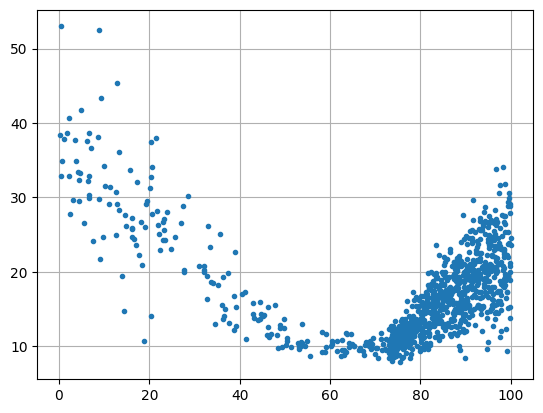

In [164]:
plt.plot(x, y, '.')
plt.grid(True)

In [165]:
def plot_piecewise_regression(pwm, x, y):
    xx = np.linspace(min(x), max(x), 1000)
    yy = pwm.predict(xx)

    if hasattr(pwm, "breakpoints_"):
        xb = pwm.breakpoints_
    else:
        xb = pwm.breakpoints

    yb = pwm.predict(xb)

    plt.figure()
    plt.plot(x, y, ".")
    plt.plot(xb, yb, "x", ms=10)
    plt.plot(xx, yy, "-")
    plt.grid(True)

In [166]:
# your desired line segment end locations
x0 = np.array([min(x), 55, 65, max(x)])

In [167]:
mod1 = pw.PiecewiseLinearRegression(breakpoints=x0, degree=[1, 0, 1])
mod1.fit(x, y)

PiecewiseLinearRegression(breakpoints=array([ 0.22865698, 55.        , 65.        , 99.97664922]),
                          degree=[1, 0, 1])

In [168]:
mod1.score(x, y)

0.6972291770079087

In [170]:
mod1.breakpoints

array([ 0.22865698, 55.        , 65.        , 99.97664922])

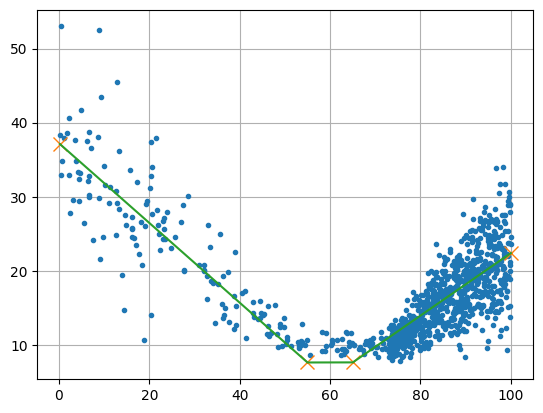

In [171]:
plot_piecewise_regression(mod1, x, y)

In [186]:
mod = pw.AutoPiecewiseRegression(n_segments=3, degree=[1, 0, 1])
mod.fit(x, y, weights=1/sigma)

AutoPiecewiseRegression(degree=[1, 0, 1], n_segments=3)

In [187]:
mod.score(x, y)

0.7060529803256984

In [188]:
mod.coef_

array([ 36.8921127 ,  -0.51758465,  10.13086693, -24.33100987,
         0.47297455])

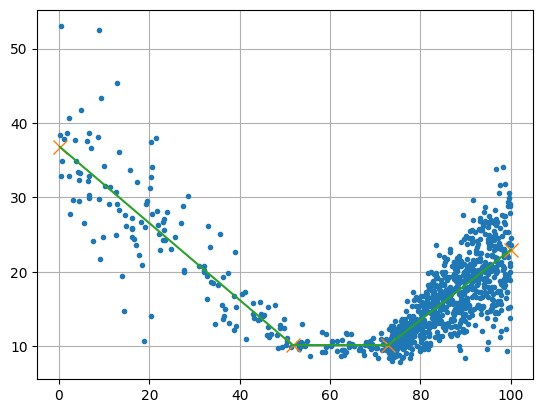

In [189]:
plot_piecewise_regression(mod, x, y)

In [126]:
mod.coef_

array([ 37.41755062,  -0.49596921,   9.83886328, -22.51726482,
         0.48785869])

In [ ]:
mod.breakpoints_

In [ ]:
mod.coef_

In [127]:
mod.score(x, y)

0.9849990759891979